# Prototype with Benchmarking

In [1]:
from itertools import product
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, accuracy_score
import statsmodels.api as sm
from tqdm.notebook import tqdm

from doe_modules.design import DOE, FullFactorial, CLOO, PlackettBurman, d_criterion, DOCLOO
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import Prototype, MLR, AbstractSimulator

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    simulator: AbstractSimulator = Prototype
    run_names: list = None
    suffix: str = "_prototype"

conf = Config()

Text(0.5, 1.0, 'Prototype-59048')

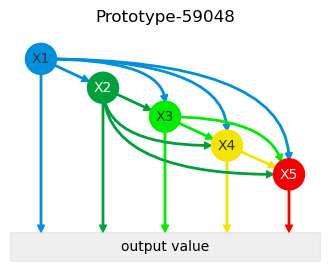

In [3]:
fig, ax = plt.subplots(figsize=(4, 3))

conf.simulator(edge_assignsment=[1] * 10).plot(ax=ax)
ax.set_title(conf.simulator(edge_assignsment=[1] * 10, model_id=3 ** 10 - 1).name)

# if conf.savefig:
#     fig.savefig(f"{conf.out}/sim_model{conf.suffix}", **kwarg_savefig)

In [4]:
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

conditions = dict(
    ff=[conf.simulator(v, model_id=i) for i, v in enumerate(edges)],
    pb=[conf.simulator(v, model_id=i) for i, v in enumerate(edges)],
    cloo=[conf.simulator(v, model_id=i) for i, v in enumerate(edges)],
)

designs = dict(
    ff=FullFactorial,
    pb=PlackettBurman,
    cloo=CLOO,
)

In [5]:
for k, models in tqdm(conditions.items(), total=3):
    [
        m.simulate(
            design=designs[k], n_rep=3
        ) for (i, m) in tqdm(enumerate(models), total=len(edges))
    ]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/59049 [00:00<?, ?it/s]

IOStream.flush timed out


  0%|          | 0/59049 [00:00<?, ?it/s]

  0%|          | 0/59049 [00:00<?, ?it/s]

fig, ax = plt.subplots(1, 3, figsize=(9, 6))

for i, a in enumerate(ax.ravel()):
    ff_mlr = MLR(conditions["ff"][3 * i + 2])
    ff_mlr.plot(anova=True, jitter_ratio=.05, ax=a)
    a.set_title(noise_names[i])

fig.suptitle(f"{conf.simulator().name} analyzed with {ff_mlr.metadata['design']} design (N=3)", y=.95)

if conf.savefig:
    fig.savefig(f"{conf.out}/groundtrue_results{conf.suffix}", **kwarg_savefig)

In [ ]:
ground_truth = [
    MLR(v).summary(
        anova=True, dtype=int
    ) for v in tqdm(conditions["ff"], total=len(edges))
]

pb_k, cloo_k = [], []
pb_dd, cloo_dd = [], []

def kappa(res, gt):
    if gt.unique().size == 1:
        f = lambda res, gt: accuracy_score(res, gt)
    else:
        f = lambda res, gt: cohen_kappa_score(res, gt, weights="linear")
    return np.nan if res.isna().all() else f(res, gt)

# kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

for (pb, cloo, gt) in tqdm(zip(conditions["pb"], conditions["cloo"], ground_truth), total=len(edges)):
    pb_res = MLR(pb).summary(anova=True, dtype=int)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int)
    pb_k += [kappa(pb_res, gt)]
    cloo_k += [kappa(cloo_res, gt)]

  0%|          | 0/59049 [00:00<?, ?it/s]

  0%|          | 0/59049 [00:00<?, ?it/s]

In [67]:
def voronoi(c_p):
    c, p = c_p
    if c < .6 and p < .6:
        ret = 0
    elif c > p:
        ret = 1
    elif c < p:
        ret = 2
    else:
        ret = 3
    return ret

def voronoi_label(c_p):
    return ["neither", "C+LOO", "PB", "both"][voronoi(c_p)]

In [68]:
dat = pd.DataFrame({
    "cloo": cloo_k,
    "pb": pb_k,
    "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
})

dat.to_feather(f"{conf.out}/esm{conf.suffix}.feather")

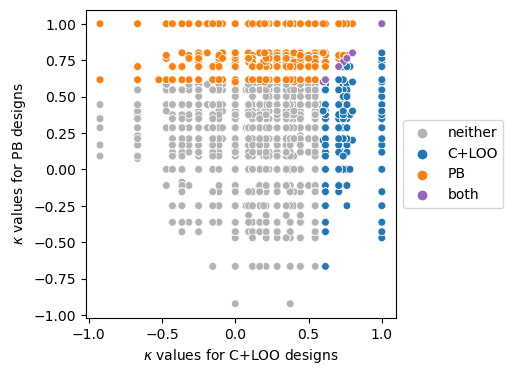

In [69]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    dat.sort_values("v"),
    x="cloo", 
    y="pb", 
    hue="",
    palette=[".7", "C0", "C1", "C4"],
    s=30, 
    # linewidth=0
)

ax.set(
    xlabel="$\kappa$ values for C+LOO designs", 
    ylabel="$\kappa$ values for PB designs"
)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

if conf.savefig:
    fig.savefig(f"{conf.out}/kappa_scatter{conf.suffix}", **kwarg_savefig)

In [34]:
def n_pathways(arr) -> int:
    return 5

# def hetero(arr) -> float:
#     return 0 if (arr == 0).all() else arr[arr != 0].std()

# def n_bimodal(arr) -> float:
#     bimodal = lambda x: 1 if (x > 0).any() and (x < 0).any() else 0
#     return bimodal(arr[(0, 4, 5, 6),]) + bimodal(arr[(1, 7, 8),]) + bimodal(arr[(1, 7, 8),]) + bimodal(arr[(2, 9),])

# def n_sep(arr) -> int:
#     return int(
#         (np.abs(arr)[4:7] == 0).all() and arr[0] != 0
#     ) + int(
#         (np.abs(arr)[7:9] == 0).all() and (arr[1] != 0
#     ) + int(
#         (np.abs(arr)[9:] == 0).all() and arr[2] != 0
#     ) + int(arr[3] != 0)

def voronoi(c_p):
    c, p = c_p
    if c < .6 and p < .6:
        ret = 0
    elif c > p:
        ret = 1
    elif c < p:
        ret = 2
    else:
        ret = 3
    return ret

def voronoi_label(c_p):
    return ["neither", "C+LOO", "PB", "both"][voronoi(c_p)]

# def neg1(arr):
#     return (arr == -1).sum()

def neg2(arr):
    return (arr == - 1).sum()

def n_pos(arr):
    return (arr == 1).sum()

n_neg = neg2

# def neg3(arr):
#     return (arr[:4] == -1).sum()

def cai(arr) -> float:
    ep = n_pos(arr)
    e = np.abs(arr).sum()
    e_theoretical = len(arr)

    e_coverage = e / e_theoretical
    positivity = 0 if e == 0 else ep / e

    return np.mean([e_coverage, positivity])

In [26]:
dat = pd.DataFrame({
    "cloo": cloo_k,
    "pb": pb_k,
    "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "n_edges": list(map(lambda x: np.abs(x).sum(), edges)),
    # "n_path": list(map(n_pathways, edges)),
    # "edge_hetero": list(map(hetero, edges)),
    # "n_bimodal": list(map(n_bimodal, edges)),
    # "n_neg1": list(map(neg1, edges)),
    "n_pos": list(map(n_pos, edges)),
    "n_neg": list(map(neg2, edges)),
    # "n_neg3": list(map(neg3, edges)),
    # "n_sep": list(map(n_sep, edges)),
    # "feat": np.fromiter(map(lambda x: np.abs(x[4:]).sum(), edges), dtype=int) * np.fromiter(map(n_pos, edges), dtype=int),
    "cai": list(map(cai, edges)),
})

In [27]:
feat = [
    "n_edges", 
    # "n_path", 
    # "edge_hetero", 
    # "n_bimodal", 
    # "n_sep", 
    "n_pos",
    # "n_neg1", "n_neg2", "n_neg3",
    "n_neg",
    # "feat", 
    # "feat2",
    "cai",
]

In [28]:
corr = dat.loc[:, ["cloo", "pb"] + feat].corr(method="spearman")
corr

# fig, ax = plt.subplots(figsize=(3, 3))

# sns.heatmap(
#     corr,
#     vmax=1, vmin=-1, cmap="coolwarm", square=True, fmt=".2f", annot=True
# )

# ax.set_xticklabels([
#     "$\kappa$\n(C+LOO)", "$\kappa$\n(PB)", "$|E|$", "$|P|$", "$|E_{-}|$"
# ])
# ax.set_yticklabels([
#     "$\kappa$\n(C+LOO)", "$\kappa$\n(PB)", "$|E|$", "$|P|$", "$|E_{-}|$"
# ]);

,cloo,pb,n_edges,n_pos,n_neg,cai
cloo,1.000000,0.071286,-0.050279,0.065548,-0.113890,0.056715
pb,0.071286,1.000000,-0.066793,-0.107870,0.031625,-0.100858
n_edges,-0.050279,-0.066793,1.000000,0.483627,0.483627,0.595612
n_pos,0.065548,-0.107870,0.483627,1.000000,-0.483627,0.975144
n_neg,-0.113890,0.031625,0.483627,-0.483627,1.000000,-0.354948
cai,0.056715,-0.100858,0.595612,0.975144,-0.354948,1.000000


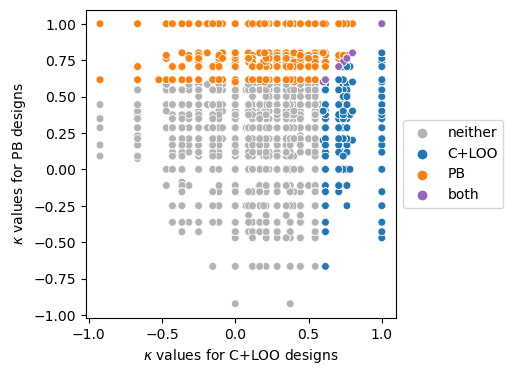

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    dat.sort_values("v"),
    x="cloo", 
    y="pb", 
    hue="",
    palette=[".7", "C0", "C1", "C4"],
    s=30, 
    # linewidth=0
)

ax.set(
    xlabel="$\kappa$ values for C+LOO designs", 
    ylabel="$\kappa$ values for PB designs"
)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

# if conf.savefig:
#     fig.savefig(f"{conf.out}/kappa_scatter{conf.suffix}", **kwarg_savefig)

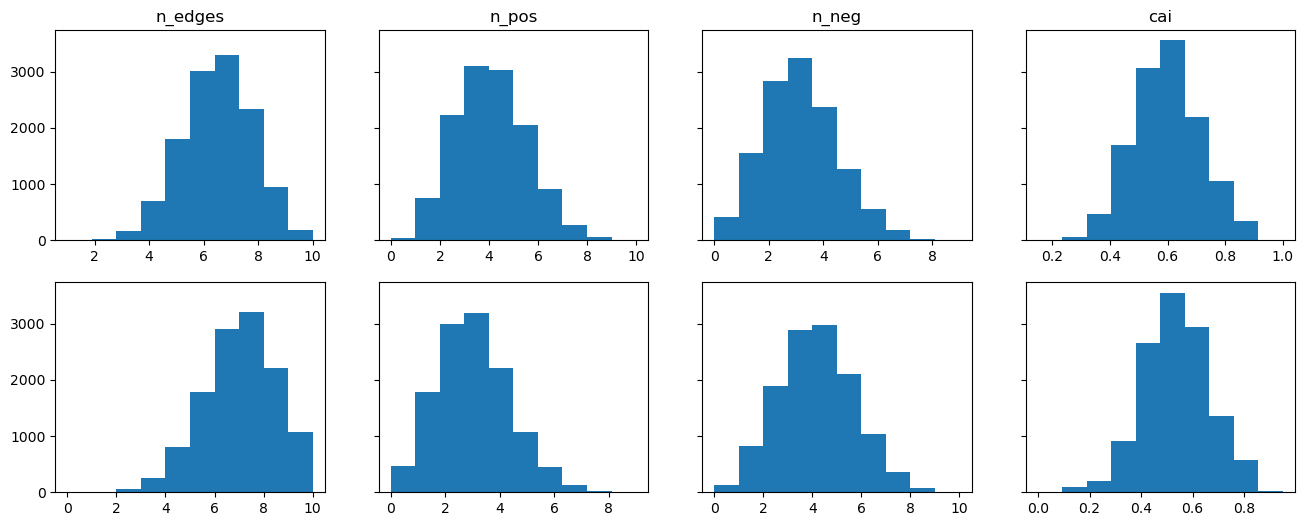

In [30]:
fig, ax = plt.subplots(2, len(feat), figsize=(4 * len(feat), 6), sharey=True)

for i, k in enumerate(feat):
    ax[0, i].hist(dat[dat.loc[:, ""] == "C+LOO"].loc[:, k])
    ax[1, i].hist(dat[dat.loc[:, ""] == "PB"].loc[:, k])
    ax[0, i].set_title(k)

In [31]:
def stacked_tally(df, key: str, groupby: str, stack_key: str = None, ascending: bool = True, ratio: bool = False, geq: bool = False):
    f = lambda d, b: d / d.sum() if b else d
    g = lambda d, k, v, b: d[d.loc[:, k] >= v] if b else d[d.loc[:, k] == v]
    h = lambda d, arr: pd.Series([d[name] if name in d.index else 0 for name in arr], index=arr, name=d.name)
    stack_key = stack_key if stack_key is not None else groupby
    stack_order = df.sort_values(stack_key if stack_key is not None else groupby, ascending=ascending).loc[:, groupby].unique()
    return pd.concat([
        f(
            h(g(df, key, v, geq).loc[:, groupby].value_counts(), stack_order), 
            ratio
        ).cumsum().reset_index().assign(key=v) for v in np.sort(df.loc[:, key].unique())
    ])

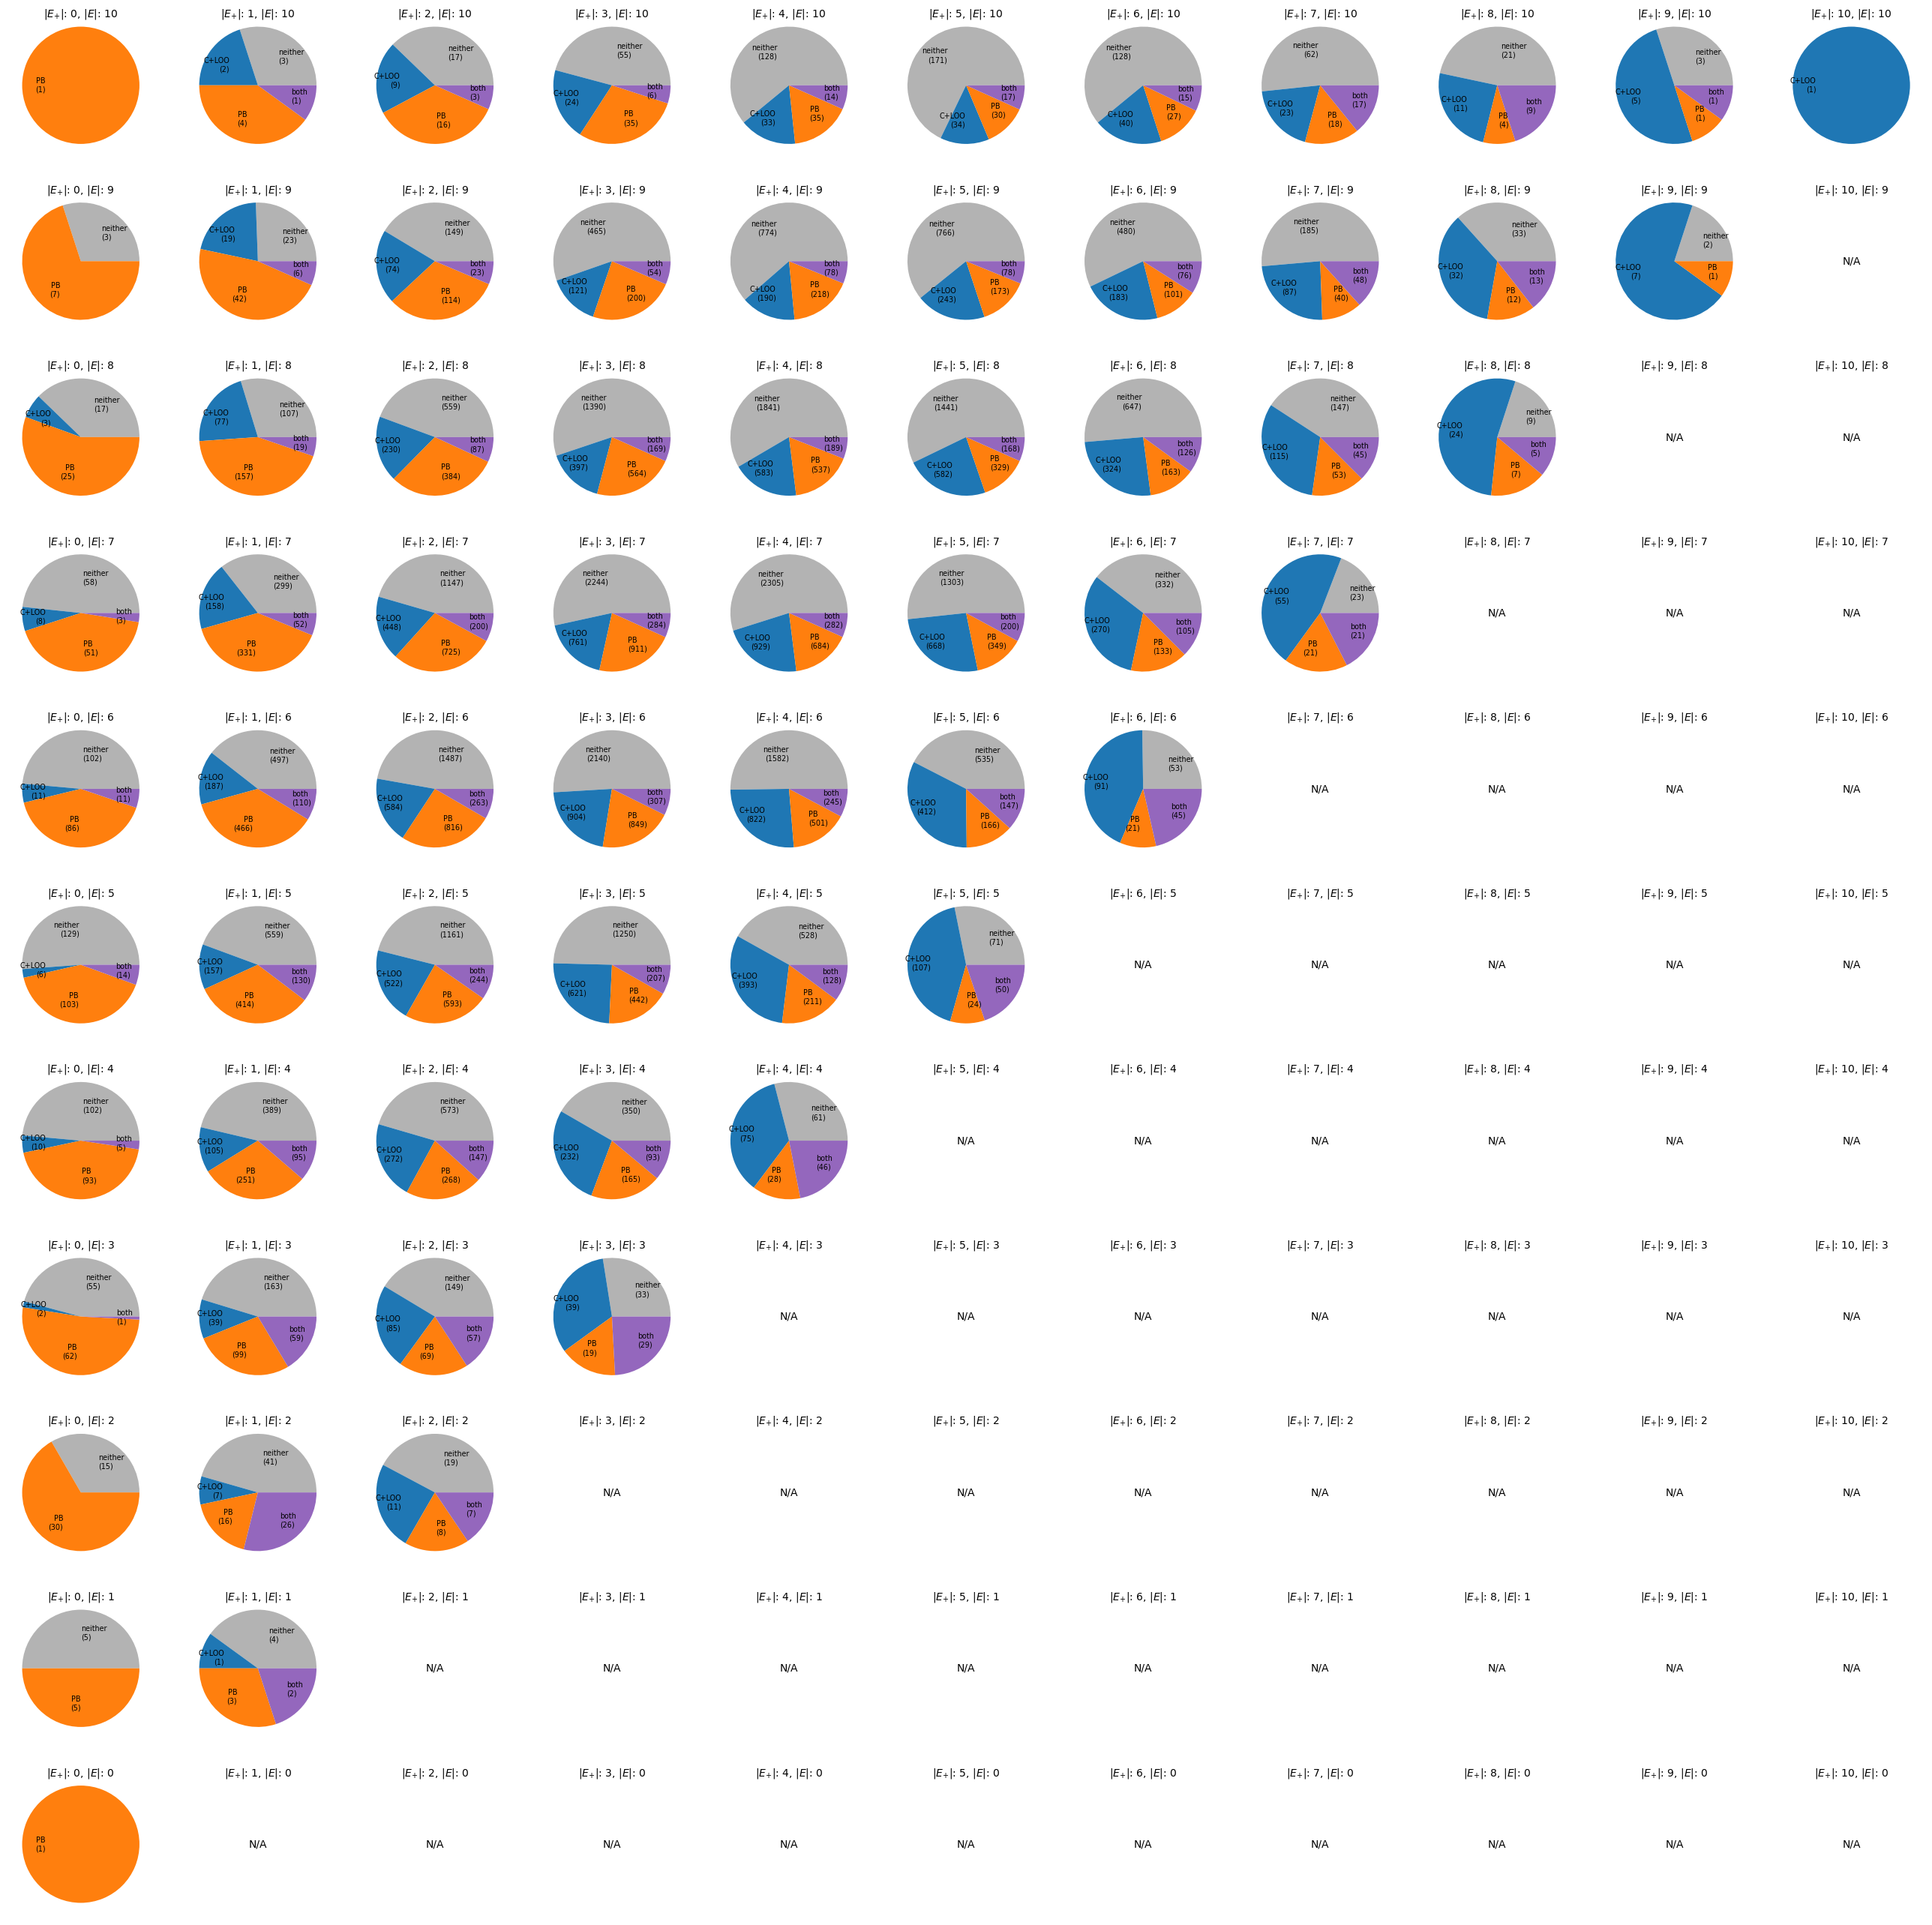

In [32]:
key_r, key_c = "n_edges", "n_pos"
label_r, label_c = "$|E|$", "$|E_{+}|$"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")
        # a.text(
        #     0, 1.1, 
        #     f"${latexify(key_c)}$: {i % ncol}, ${latexify(key_r)}$: {nrow - 1 - i // ncol}", 
        #     ha="center", va="bottom"
        # )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)

key_r, key_c = "n_edges", "n_path"
label_r, label_c = "$|E|$", "$|P|$"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {0: "poor", 1: "C+LOO", 2: "PB", 3: "equal"}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")

if conf.savefig:
    fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)

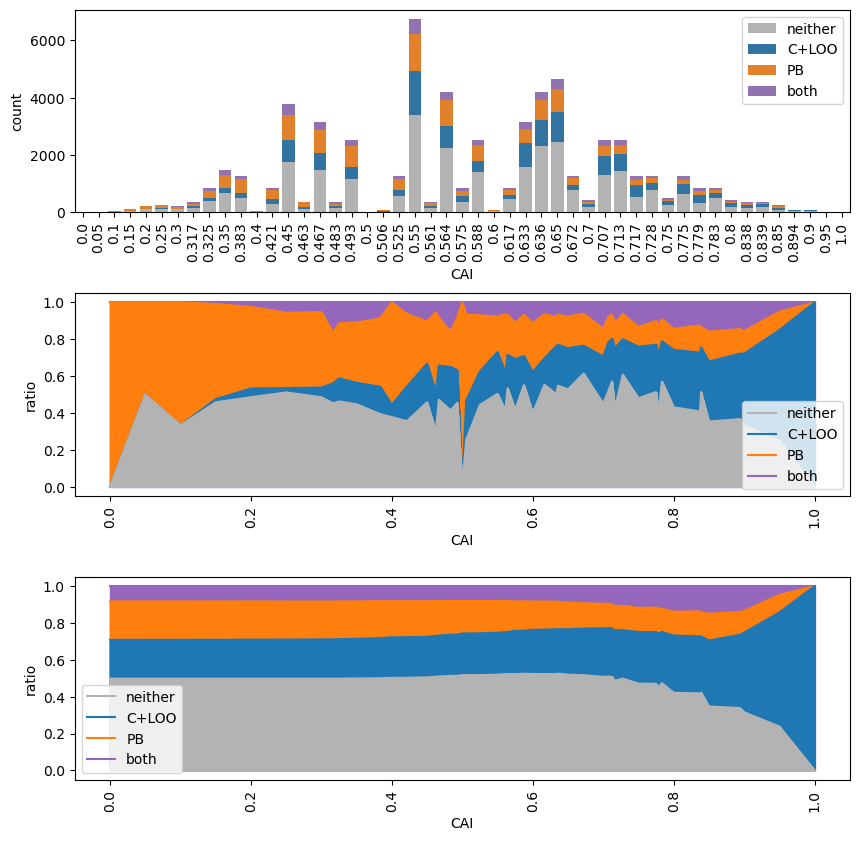

In [53]:
df = stacked_tally(dat, "cai", "", stack_key="v", ratio=False)
df2 = stacked_tally(dat, "cai", "", stack_key="v", ratio=True)
df3 = stacked_tally(dat, "cai", "", stack_key="v", ratio=True, geq=True)

fig, ax = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=.4)

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.barplot(
        data=df[df.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.lineplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )
    for line_idx, line in enumerate(ax[1].lines):
        x, y = line.get_xydata().T
        ax[1].fill_between(x, 0, y, color=line.get_color(), alpha=1, zorder=-line_idx)
    sns.lineplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[2],
        zorder=-i, label=k
    )
    for line_idx, line in enumerate(ax[2].lines):
        x, y = line.get_xydata().T
        ax[2].fill_between(x, 0, y, color=line.get_color(), alpha=1, zorder=-line_idx)

ax[0].legend()
ax[0].set_xticklabels([f"{round(float(v.get_text()), 3)}" for v in ax[0].get_xticklabels()])
# ax[2].set_xticklabels([r"$\geq$" + f"{v.get_text()}" for v in ax[2].get_xticklabels()])
[a.xaxis.set_tick_params(rotation=90) for a in ax.ravel()]

[
    a.set(
        xlabel="CAI",
        ylabel=(["count"] + ["ratio"] * 2)[i]
    ) for i, a in enumerate(ax)
];

# if conf.savefig:
#     fig.savefig(f"{conf.out}/bar_n_edges_n_path{conf.suffix}", **kwarg_savefig)

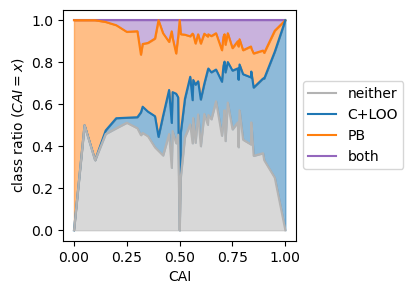

In [58]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.lineplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax,
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax.lines):
    x, y = line.get_xydata().T
    ax.fill_between(x, 0 if line_idx == 0 else bottom, y, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="CAI", ylabel="class ratio ($CAI=x$)")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/bar_cai{conf.suffix}", **kwarg_savefig)

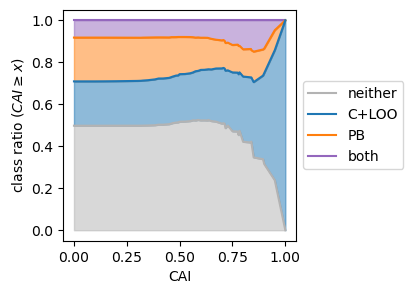

In [59]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.lineplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax,
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax.lines):
    x, y = line.get_xydata().T
    ax.fill_between(x, 0 if line_idx == 0 else bottom, y, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))
ax.set(xlabel="CAI", ylabel="class ratio ($CAI\geq x$)")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/bar_cai_geq{conf.suffix}", **kwarg_savefig)

In [66]:
(12 / 36 + 7 / 12 + 11 / 11) / 3

0.638888888888889

In [33]:
def n_pathways(arr) -> int:
    return np.abs(arr)[:4].sum()

def hetero(arr) -> float:
    return 0 if (arr == 0).all() else arr[arr != 0].std()

def n_bimodal(arr) -> float:
    bimodal = lambda x: 1 if (x > 0).any() and (x < 0).any() else 0
    return bimodal(arr[(0, 4, 5, 6),]) + bimodal(arr[(1, 7, 8),]) + bimodal(arr[(1, 7, 8),]) + bimodal(arr[(2, 9),])

def n_sep(arr) -> int:
    return int(
        (np.abs(arr)[4:7] == 0).all()
    ) + int(
        (np.abs(arr)[7:9] == 0).all()
    ) + int(
        (np.abs(arr)[9:] == 0).all()
    ) + 1

def voronoi(c_p):
    c, p = c_p
    if c < .6 and p < .6:
        ret = 0
    elif c > p:
        ret = 1
    elif c < p:
        ret = 2
    else:
        ret = 3
    return ret

def voronoi_label(c_p):
    return ["poor", "C+LOO", "PB", "equal"][voronoi(c_p)]

In [ ]:
dat = pd.DataFrame({
    "cloo": cloo_k,
    "pb": pb_k,
    "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "n_edges": list(map(lambda x: np.abs(x[4:]).sum(), edges)),
    "n_path": list(map(n_pathways, edges)),
    "edge_hetero": list(map(hetero, edges)),
    "n_bimodal": list(map(n_bimodal, edges)),
    "n_sep": list(map(n_sep, edges)),
    "feat": (4 - np.fromiter(map(n_pathways, edges), dtype=int)) * np.fromiter(map(n_bimodal, edges), dtype=int),
    "feat2": (6 - np.fromiter(map(lambda x: np.abs(x[4:]).sum(), edges), dtype=int)) * np.fromiter(map(n_pathways, edges), dtype=int)
})

In [ ]:
feat = [
    "n_edges", "n_path", "edge_hetero", "n_bimodal", "n_sep", "feat", "feat2"
]

In [ ]:
dat.loc[:, ["cloo", "pb"] + feat].corr(method="spearman")

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    dat.sort_values("v"),
    x="cloo", 
    y="pb", 
    hue="",
    palette=[".7", "C0", "C1", "C4"],
    s=3, linewidth=0
)

ax.set(
    xlabel="$\kappa$ values for C+LOO designs", 
    ylabel="$\kappa$ values for PB designs"
)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

In [ ]:
fig, ax = plt.subplots(2, len(feat), figsize=(4 * len(feat), 6), sharey=True)

for i, k in enumerate(feat):
    ax[0, i].hist(dat[dat.loc[:, ""] == "C+LOO"].loc[:, k])
    ax[1, i].hist(dat[dat.loc[:, ""] == "PB"].loc[:, k])
    ax[0, i].set_title(k)

In [ ]:
def stacked_tally(df, key: str, groupby: str, stack_key: str = None, ascending: bool = True, ratio: bool = False, geq: bool = False):
    f = lambda d, b: d / d.sum() if b else d
    g = lambda d, k, v, b: d[d.loc[:, k] >= v] if b else d[d.loc[:, k] == v]
    h = lambda d, arr: pd.Series([d[name] if name in d.index else 0 for name in arr], index=arr, name=d.name)
    stack_key = stack_key if stack_key is not None else groupby
    stack_order = df.sort_values(stack_key if stack_key is not None else groupby, ascending=ascending).loc[:, groupby].unique()
    return pd.concat([
        f(
            h(g(df, key, v, geq).loc[:, groupby].value_counts(), stack_order), 
            ratio
        ).cumsum().reset_index().assign(key=v) for v in np.sort(df.loc[:, key].unique())
    ])

In [ ]:
df = stacked_tally(dat, "feat", "", stack_key="v", ratio=False)
df2 = stacked_tally(dat, "feat", "", stack_key="v", ratio=True)
df3 = stacked_tally(dat, "feat", "", stack_key="v", ratio=True, geq=True)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
plt.subplots_adjust(wspace=.3)

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.barplot(
        data=df[df.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[2],
        zorder=-i, label=k
    )

ax[0].legend()
ax[2].set_xticklabels([r"$\geq$" + f"{v}" for v in df3.key.unique()])
ax[2].xaxis.set_tick_params(rotation=30)

[
    a.set(
        xlabel=r"$(4-n_{path})\cdot n_{bimodal}$",
        ylabel=(["count"] + ["ratio"] * 2)[i]
    ) for i, a in enumerate(ax)
];

In [ ]:
key_r, key_c = "n_bimodal", "n_path"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {0: "poor", 1: "C+LOO", 2: "PB", 3: "equal"}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"${latexify(key_r)}$: {nrow - 1 - i // ncol}, ${latexify(key_c)}$: {i % ncol}", ha="center", va="bottom")
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")

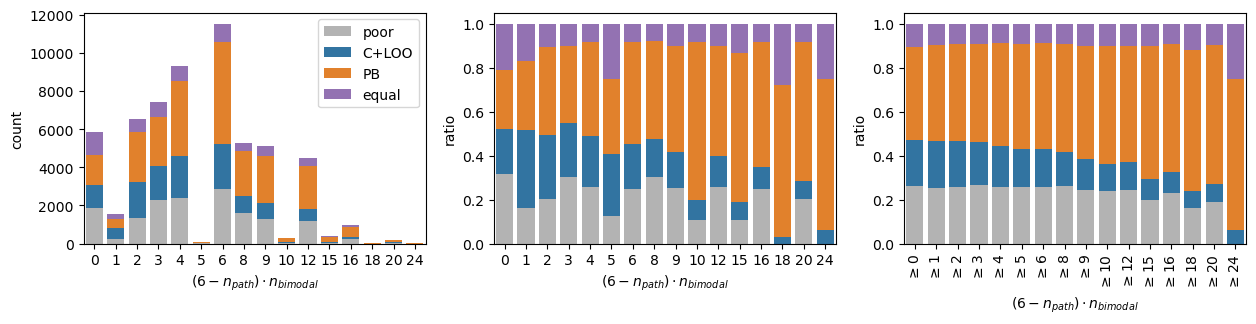

In [680]:
df = stacked_tally(dat, "feat2", "", stack_key="v", ratio=False)
df2 = stacked_tally(dat, "feat2", "", stack_key="v", ratio=True)
df3 = stacked_tally(dat, "feat2", "", stack_key="v", ratio=True, geq=True)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
plt.subplots_adjust(wspace=.2)

for i, k in enumerate(df.loc[:, "index"].unique()):
    sns.barplot(
        data=df[df.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df2[df2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )
    sns.barplot(
        data=df3[df3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[2],
        zorder=-i, label=k
    )

ax[0].legend()
ax[2].set_xticklabels([r"$\geq$" + f"{v.get_text()}" for v in ax[2].get_xticklabels()])
ax[2].xaxis.set_tick_params(rotation=90)

[
    a.set(
        xlabel=r"$(6-n_{path})\cdot n_{bimodal}$",
        ylabel=(["count"] + ["ratio"] * 2)[i]
    ) for i, a in enumerate(ax)
];

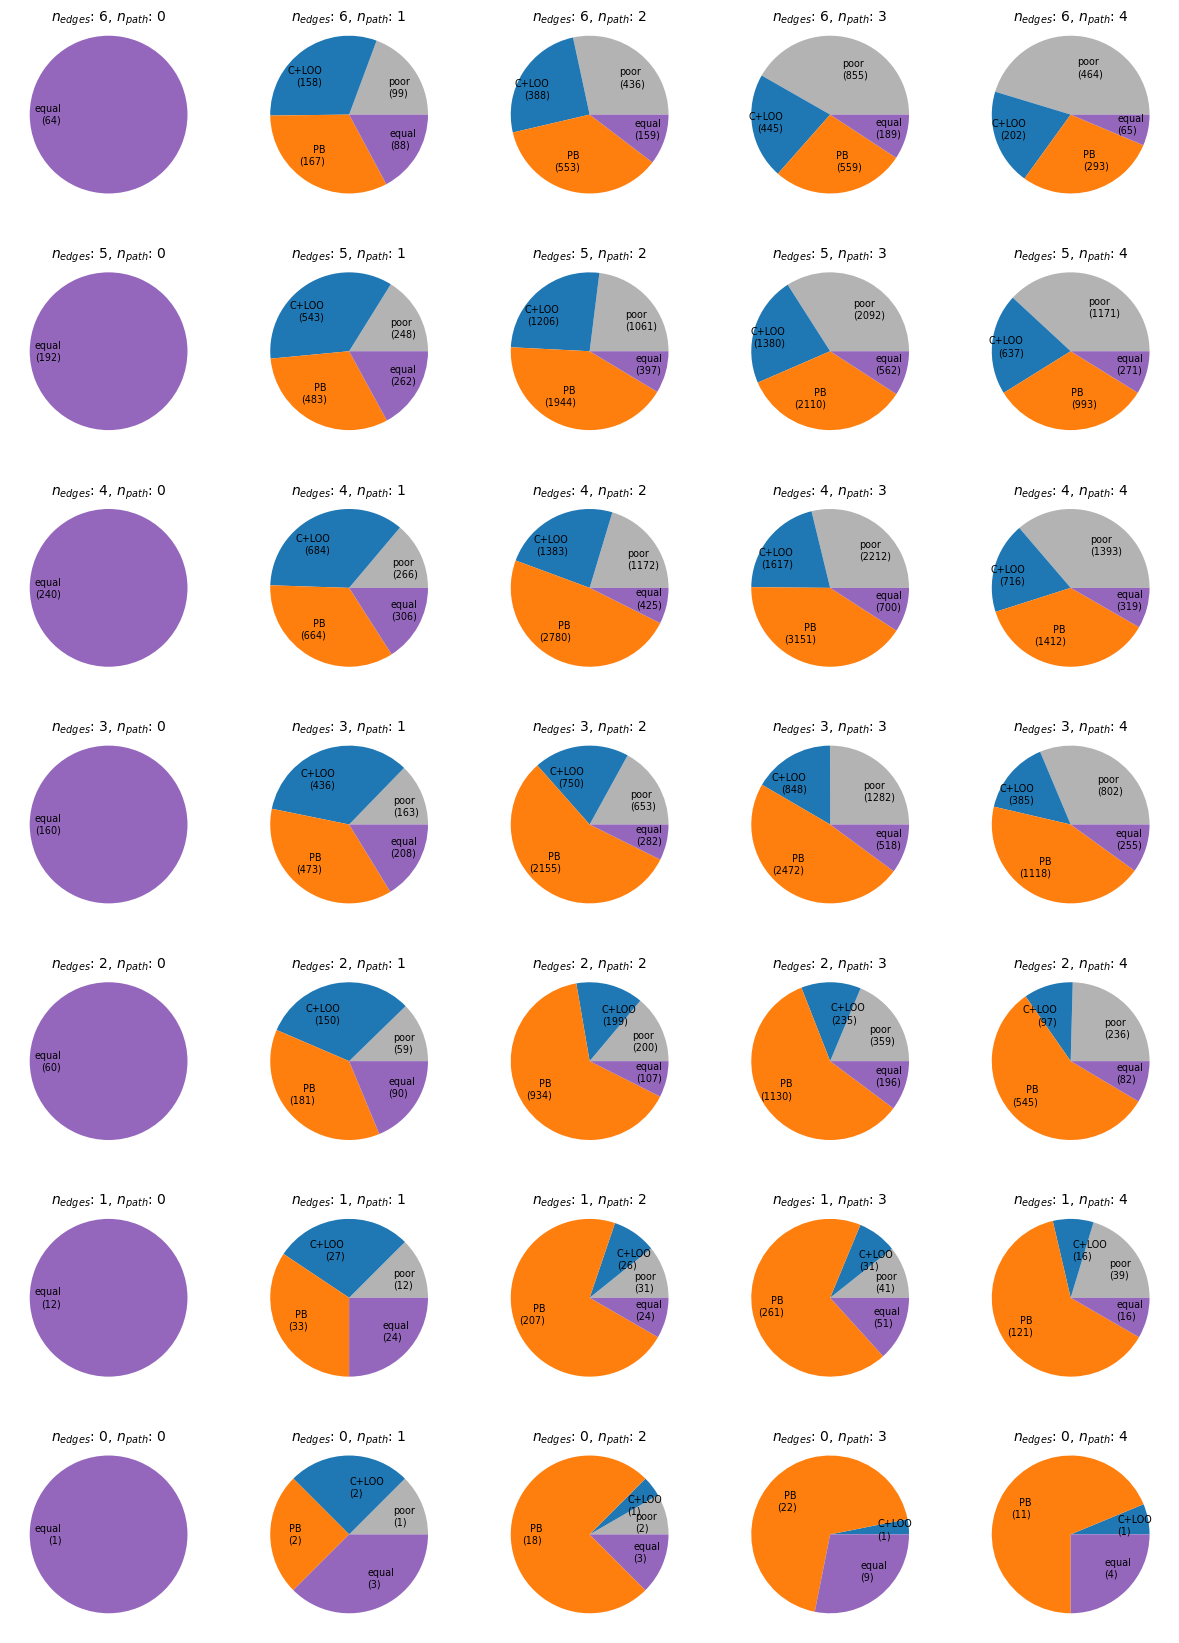

In [564]:
key_r, key_c = "n_edges", "n_path"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {0: "poor", 1: "C+LOO", 2: "PB", 3: "equal"}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"${latexify(key_r)}$: {nrow - 1 - i // ncol}, ${latexify(key_c)}$: {i % ncol}", ha="center", va="bottom")
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")

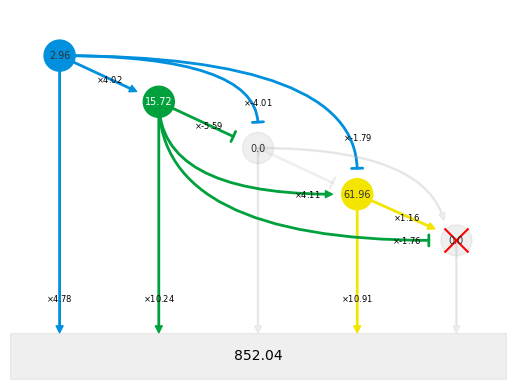

In [ ]:
fig, ax = plt.subplots()

models[40265].plot(ax)

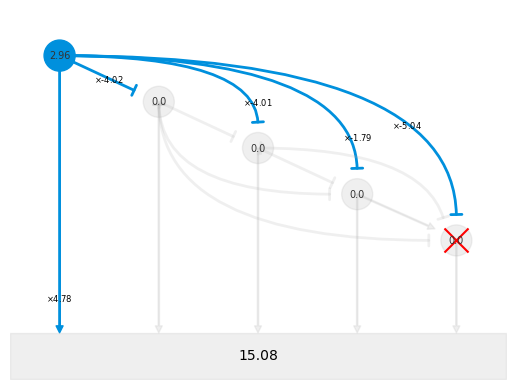

In [43]:
fig, ax = plt.subplots()

models[2].plot(ax)

In [44]:
ground_truth[2]

X1   -1
X2    0
X3   -1
X4    1
X5    0
dtype: int64

In [21]:
edges[2]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  1])

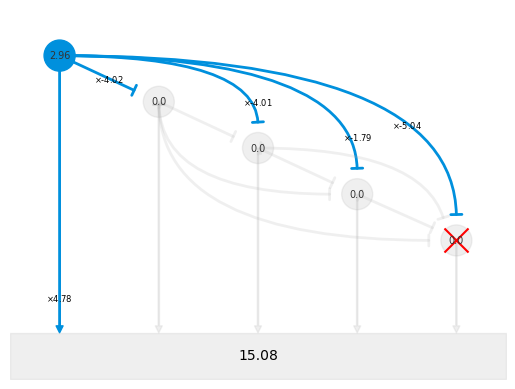

In [22]:
fig, ax = plt.subplots()

models[0].plot(ax)

In [23]:
def n_pathways(arr) -> int:
    return int(
        (np.abs(arr)[:4] == 0).all()
    ) + int(
        (np.abs(arr)[4:7] == 0).all()
    ) + int(
        (np.abs(arr)[7:9] == 0).all()
    ) + int(
        (np.abs(arr)[9:] == 0).all()
    ) + 1

In [141]:
(len(edges) - 1) / 2

29524.0

In [137]:
n_pathways(edges[0])

1

In [142]:
n_pathways(edges[29524])

5

In [135]:
int((np.abs(edges[0])[:4] == 0).all())

0

In [129]:
np.abs(edges[0]).sum()

10

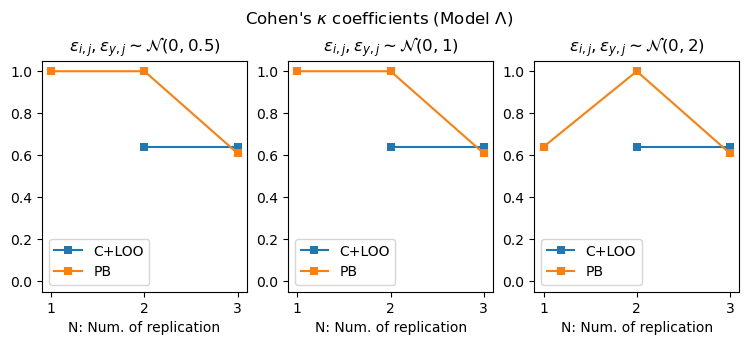

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

df = pd.DataFrame({
    "n": n_arr * 3,
    "err": np.ravel([[v] * 3 for v in [.5, 1, 2]]),
    "pb_k": pb_k,
    "cloo_k": cloo_k,
    "pb_dd": pb_dd,
    "cloo_dd": cloo_dd,
})

for i, a in enumerate(ax.ravel()):
    e = df.err.unique()[i]
    sns.lineplot(
        data=df[df.err == e], x="n", y="cloo_k", marker="s", 
        ax=a, label=conditions["cloo"][0].metadata["design"], 
        markeredgewidth=0,
    )
    sns.lineplot(
        data=df[df.err == e], x="n", y="pb_k", marker="s", 
        ax=a, label=conditions["pb"][0].metadata["design"],
        markeredgewidth=0,
    )
    a.set_ylim(-0.05, 1.05)
    a.set(title=noise_names[i], xlabel="N: Num. of replication", ylabel="")
    a.legend(loc="best")

fig.suptitle(r"Cohen's $\kappa$" + f" coefficients ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks{conf.suffix}", **kwarg_savefig)

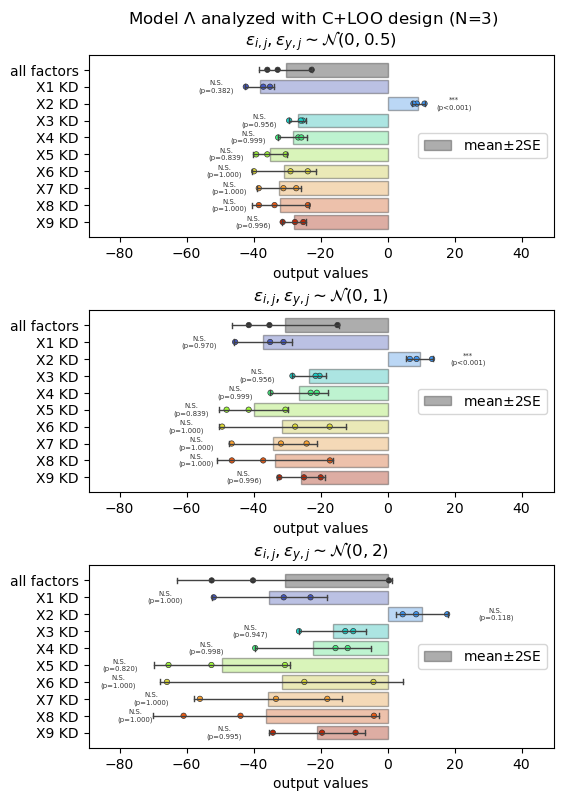

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(6, 9))
plt.subplots_adjust(hspace=.4)

for i, a in enumerate(ax.ravel()):
    model = conditions["cloo"][3 * i + 2]
    bio_multicomp(model, cmap=model.cmap, ax=a, text_kwargs={"size": 5}, xscales=[1.2, 2.2], jitter_ratio=.15)
    a.set_title(noise_names[i])

    # for x, y, t, c in zip([-160, 120], [0, 0], ["Upregulation", "Downregulation"], ["C3", "C0"]):
    #     a.text(x, y, t, color=c, ha="center", va="center", size=11)

    a.legend(loc="center right")

xlim = (lambda arr: [arr.min(), arr.max()])(np.array([a.get_xlim() for a in ax.ravel()]))

[a.set_xlim(*xlim) for a in ax.ravel()]
    
fig.suptitle(f"{conf.simulator().name} analyzed with {model.metadata['design']} design (N={model.metadata['n_rep']})", y=.93)

if conf.savefig:
    fig.savefig(f"{conf.out}/intuitive_plots_for_benchmarking{conf.suffix}", **kwarg_savefig)

In [11]:
n_add = [2, 6, 10]

doptims = dict(
    docloo=list(map(lambda x: x(), [conf.simulator] * len(noise_conf) * len(n_add)))
)

In [12]:
for i, m in enumerate(doptims["docloo"]):
    m.simulate(
        design=DOCLOO,
        n_rep=3,
        n_add = n_add[i % len(n_add)],
        model_kwargs=noise_conf[i // len(n_add)],
    )

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Warning message:
In optFederov(~., rbind(arr, candidate), nTrials = nrow(arr) + opts$add,  :
  NAs introduced by coercion to integer range
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this wa

In [13]:
do_k = []

for do, gt in zip(doptims["docloo"], ground_truth):
    do_res = MLR(do).summary(anova=True, dtype=int)
    do_k += [kappa(do_res, gt)]

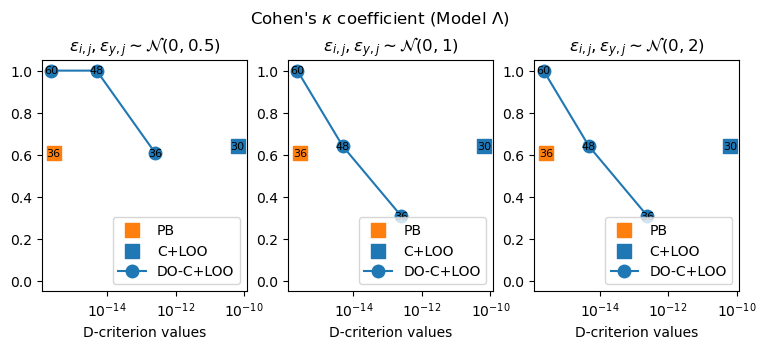

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

df2 = pd.DataFrame({
    "nmax": [len(m.exmatrix) for m in doptims["docloo"]],
    "d": np.fromiter(
        map(
            d_criterion, 
            map(
                sm.add_constant, 
                [m.exmatrix for m in doptims["docloo"]]
            )
        ), 
        float
    ),
    "err": np.ravel([[v] * 3 for v in [.5, 1, 2]]),
    "do_k": do_k
})

d_pb = d_criterion(sm.add_constant(pb.exmatrix))
d_cloo = d_criterion(sm.add_constant(cloo.exmatrix))

for i, a in enumerate(ax.ravel()):
    e = df2.err.unique()[i]
    pb = conditions["pb"][3 * i + 2]
    cloo = conditions["cloo"][3 * i + 2]
    a.scatter(d_pb, pb_k[3 * i + 2], marker=",", color="C1", label="PB", s=100)
    a.scatter(d_cloo, cloo_k[3 * i + 2], marker=",", color="C0", label="C+LOO", s=100)
    sns.lineplot(
        data=df2[df2.err == e], x="d", y="do_k", marker="o", 
        ax=a, label="DO-C+LOO", 
        markeredgewidth=0, color="C0", markersize=10
    )
    a.set_ylim(-0.05, 1.05)
    a.set(title=noise_names[i], xlabel="D-criterion values", ylabel="")
    a.set_xscale("log")
    a.legend(loc="lower right")
    
    for x, y, t in zip(
        list(df2[df2.err == e].d) + [d_pb, d_cloo],
        list(df2[df2.err == e].do_k) + [pb_k[3 * i + 2], cloo_k[3 * i + 2]],
        list(df2[df2.err == e].nmax) + [len(pb.exmatrix), len(cloo.exmatrix)],
    ):
        a.text(x, y, t, ha="center", va="center", size=8)

fig.suptitle(r"Cohen's $\kappa$" + f" coefficient ({conf.simulator().name})", y=1.05)

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmarks_with_do{conf.suffix}", **kwarg_savefig)